In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=3

### Load Dataset

In [11]:
#Load Dataset
data_variance, train_set, val_set, val_len = load_FloorPlan(multi_scale=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([3, 56, 56]), dataset size: 2806, data variance: 0.012449867092072964


### Load Best or Train

In [12]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [62]:
vqvae.load_state_dict(torch.load("checkpoint/140-vqae-0.14986537524632043.pt"))
optimizer.load_state_dict(torch.load("checkpoint/140-adam-0.14986537524632043.pt"))

with open("checkpoint/140-vqae_train-0.14986537524632043.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("checkpoint/140-vqae_test-0.14986537524632043.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 140
end_epoch = 150
best_loss = 0.14986537524632043

##### train

In [45]:
for epoch in range(start_epoch+1, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.191]


Validation Loss: 0.23448781285967146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23batch/s, loss=0.241]


Validation Loss: 0.2915800843920026


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32batch/s, loss=0.227]


Validation Loss: 0.26992744037083216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.26batch/s, loss=0.277]


Validation Loss: 0.4160943031311035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28batch/s, loss=0.221]


Validation Loss: 0.26246512957981655


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.21batch/s, loss=0.257]


Validation Loss: 0.23742312703813825


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.209]


Validation Loss: 0.25145845413208007


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10batch/s, loss=0.227]


Validation Loss: 0.22434327261788506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.199]


Validation Loss: 0.23143442017691476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.229]


Validation Loss: 0.23253132275172642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.191]


Validation Loss: 0.24254827499389647


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10batch/s, loss=0.248]


Validation Loss: 0.2168325287955148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.194]


Validation Loss: 0.2162937981741769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.18]


Validation Loss: 0.21693957192557198


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.10batch/s, loss=0.183]


Validation Loss: 0.21503139223371232


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.181]


Validation Loss: 0.2395002910069057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.16batch/s, loss=0.176]


Validation Loss: 0.20878518649509975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06batch/s, loss=0.226]


Validation Loss: 0.21924823352268763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.191]


Validation Loss: 0.20605694907052174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.214]


Validation Loss: 0.20253236634390692


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.207]


Validation Loss: 0.22452432087489538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.13batch/s, loss=0.183]


Validation Loss: 0.20369056292942594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.15batch/s, loss=0.183]


Validation Loss: 0.2091217517852783


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.12batch/s, loss=0.202]


Validation Loss: 0.20439851624625072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05batch/s, loss=0.274]


Validation Loss: 0.20606275285993303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.97batch/s, loss=0.168]


Validation Loss: 0.19192993300301686


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.176]


Validation Loss: 0.18836708750043596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.29batch/s, loss=0.191]


Validation Loss: 0.20249603135245187


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.249]


Validation Loss: 0.18616818359919957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.218]


Validation Loss: 0.18948480742318288


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91batch/s, loss=0.215]


Validation Loss: 0.18462516580309188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.162]


Validation Loss: 0.19487608500889372


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.153]


Validation Loss: 0.19285926137651715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.13batch/s, loss=0.156]


Validation Loss: 0.18436158043997627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.18batch/s, loss=0.176]


Validation Loss: 0.17701017175401962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.186]


Validation Loss: 0.1833137307848249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.19batch/s, loss=0.172]


Validation Loss: 0.17961321558271137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.197]


Validation Loss: 0.17398076738630022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.186]


Validation Loss: 0.1907986572810582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.164]


Validation Loss: 0.17747793878827775


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.163]


Validation Loss: 0.19273139408656528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93batch/s, loss=0.204]


Validation Loss: 0.18005952835083006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04batch/s, loss=0.156]


Validation Loss: 0.17715924467359268


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83batch/s, loss=0.156]


Validation Loss: 0.1962929998125349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04batch/s, loss=0.154]


Validation Loss: 0.1765684127807617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.165]


Validation Loss: 0.1721287046160017


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.161]


Validation Loss: 0.18102331161499025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.01batch/s, loss=0.181]


Validation Loss: 0.17494261264801025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.00batch/s, loss=0.158]


Validation Loss: 0.17694591454097203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.176]


Validation Loss: 0.1660967894962856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.163]


Validation Loss: 0.16838021618979318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.159]


Validation Loss: 0.16206745420183455


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.158]


Validation Loss: 0.16244883877890448


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.148]


Validation Loss: 0.1625584329877581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.157]


Validation Loss: 0.1676522731781006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65batch/s, loss=0.163]


Validation Loss: 0.16947927815573557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.07batch/s, loss=0.145]


Validation Loss: 0.16165521485464915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09batch/s, loss=0.161]


Validation Loss: 0.16142065525054933


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.04batch/s, loss=0.153]


Validation Loss: 0.1754812410899571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14batch/s, loss=0.168]


Validation Loss: 0.1669085877282279


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.166]


Validation Loss: 0.15639829635620117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94batch/s, loss=0.153]


Validation Loss: 0.15808756692068918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.154]


Validation Loss: 0.16052871431623186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.03batch/s, loss=0.143]


Validation Loss: 0.15211220468793596


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66batch/s, loss=0.157]


Validation Loss: 0.1569586753845215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.91batch/s, loss=0.158]


Validation Loss: 0.15551115785326278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98batch/s, loss=0.159]


Validation Loss: 0.1594439847128732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98batch/s, loss=0.135]


Validation Loss: 0.17205888543810163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.11batch/s, loss=0.165]


Validation Loss: 0.18975556577954975


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99batch/s, loss=0.169]


Validation Loss: 0.14986537524632043


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96batch/s, loss=0.148]


Validation Loss: 0.14776107924325127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05batch/s, loss=0.175]


Validation Loss: 0.19125513349260603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.88batch/s, loss=0.171]


Validation Loss: 0.15717200551714217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.05batch/s, loss=0.181]


Validation Loss: 0.16183056490761893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.06batch/s, loss=0.164]


Validation Loss: 0.16517116682870048


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09batch/s, loss=0.147]


Validation Loss: 0.15641706330435617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99batch/s, loss=0.156]


Validation Loss: 0.15153943129948208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66batch/s, loss=0.143]


Validation Loss: 0.15014187608446394


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.02batch/s, loss=0.173]


Validation Loss: 0.15931816101074217


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.08batch/s, loss=0.149]


Validation Loss: 0.19834282057625907


### Visualization

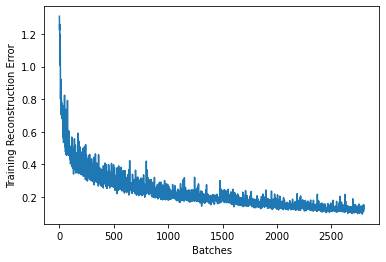

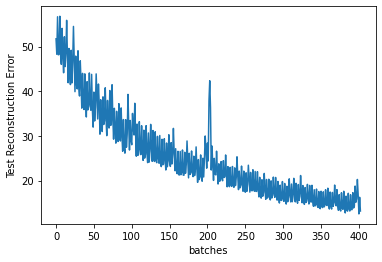

In [67]:
plt.plot(train_res_recon_error[20:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[20:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

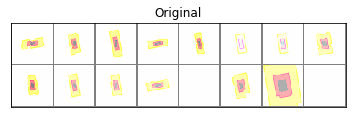

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


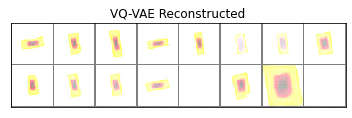

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 1, 224, 224])
torch.Size([16, 1, 224, 224])


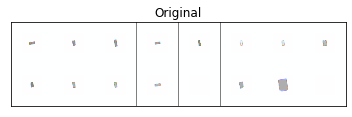

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


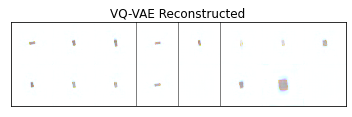

In [90]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)

def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Compose([
                                    transforms.Resize(224)])
    composed_2 = transforms.Compose([
                                    transforms.Resize(112),
                                    transforms.Pad(56, fill=1.0)])
    composed_3 = transforms.Compose([
                                    transforms.Pad(84, fill=1.0)])
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    print(channel_1.shape)
    return torch.cat([channel_1,channel_2,channel_3], dim=1)

valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()